# 20 samples (20 videos)
# 3 feature  author id (1 ~ 1000), category id (1 ~ 30). bgm id (1 ~ 100)

In [226]:
import time
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt

# Parameters initial

In [227]:
def main():
  n_num = 20
  feature_num = 3
  author_id_max = 1000
  cate_id_max = 30
  bgm_id_max = 100

  # window_size
  win_size = 10

  # rules
  author_rule = 2
  cate_rule = 3
  bgm_rule = 1

  epochs = 10000

  # plot params
  all_succ_ratios = []
  author_succ_ratios = []
  cate_succ_ratios = []
  bgm_succ_ratios = []
  s = []

  all_time = 0
  for itr in range(epochs):
    samples = generate_data(n_num, feature_num, author_id_max, cate_id_max, bgm_id_max) # generate fake data

    kwargs = {
        'samples': samples.copy(),
        'win_size': win_size,
        'author_rule': author_rule,
        'cate_rule': cate_rule,
        'bgm_rule': bgm_rule,
    }
    # record time cost
    t1 = time.time()

    # scatter
    new_samples = scatter_sliding_window(**kwargs)

    t2 = time.time()
    all_time += t2 - t1
    statistic = get_statistic(new_samples, win_size, *[author_rule, cate_rule, bgm_rule])
    
    # add to plot params
    #####################
    author_succ_ratios.append(statistic[0])
    cate_succ_ratios.append(statistic[1])
    bgm_succ_ratios.append(statistic[2])
    all_succ_ratios.append(statistic[3])
    s.append(statistic[4])
    #####################

    print(f"Epochs[{itr + 1}/{epochs}]All rules: {statistic[-1]:.4f}, author rule: {statistic[0]:.4f}, category rule: {statistic[1]:.4f}, bgm rule: {statistic[2]:.4f}")
    print(f"costs {t2 - t1:.10f}")
    # print(f"\n {samples}\n {new_samples}")
  
  # get mean statistic
  mean_all_succ_ratio = np.mean(all_succ_ratios)
  mean_author_succ_ratio = np.mean(author_succ_ratios)
  mean_cate_succ_ratio = np.mean(cate_succ_ratios)
  mean_bgm_succ_ratio = np.mean(bgm_succ_ratios)
  mean_s = np.mean(s)


  print(
      f"Average costs: {all_time / epochs:.5f}s\n"
      f"Average all rules: {mean_all_succ_ratio:.4f}\n"
      f"Average author rule: {mean_author_succ_ratio:.4f}\n"
      f"Average category rule: {mean_cate_succ_ratio:.4f}\n"
      f"Average bgm rule: {mean_bgm_succ_ratio:.4f}"
      f"Average scattering ratio: {mean_s}")
  plot_data(list(range(epochs)), *[author_succ_ratios, cate_succ_ratios, bgm_succ_ratios, all_succ_ratios])

# Generate Datasets

In [228]:
def generate_data(n_num, feature_num, author_id_max, category_id_max, bgm_id_max):
  videos = np.zeros((n_num, feature_num))
  for i in range(n_num):
    videos[i, 0] = np.random.randint(1, author_id_max + 1, (1, 1)) # author id
    videos[i, 1] = np.random.randint(1, category_id_max + 1, (1, 1)) # category id
    videos[i, 2] = np.random.randint(1, bgm_id_max + 1, (1, 1)) # bgm id
  return videos

# Scatter Algorithms

In [229]:
def scatter_sliding_window(**kwargs):
  def check(a):
    author_id = a[0]
    cate_id = a[1]
    bgm_id = a[2]
    if author_id in author_d and author_d[author_id] > author_rule:
      return False
    if cate_id in cate_d and cate_d[cate_id] > cate_rule:
      return False
    if bgm_id in bgm_d and bgm_d[bgm_id] > bgm_rule:
      return False
    return True

  
  def add2dic(item, d):
    if item not in d:
      d[item] = 0
    d[item] += 1
    return d

  samples = kwargs['samples']
  win_size = kwargs['win_size']
  author_rule = kwargs['author_rule']
  cate_rule = kwargs['cate_rule']
  bgm_rule = kwargs['bgm_rule']

  n = samples.shape[0]
  for i in range(n - win_size):
    sub_samples = samples[i:i + win_size]
    k = i + win_size
    bgm_d, author_d, cate_d = {}, {}, {}
    for j in range(win_size):
      if not check(sub_samples[j]):
        if k < n:
          samples[[i + j, k], :] = samples[[k, i + j], :]
          k += 1
        else:
          break

      author_id = sub_samples[j][0]
      cate_id = sub_samples[j][1]
      bgm_id = sub_samples[j][2]

      author_d = add2dic(author_id, author_d)
      cate_d = add2dic(cate_id, cate_d)
      bgm_d = add2dic(bgm_id, bgm_d)

  return samples

# Compute success ratio

In [230]:
def get_statistic(samples, win_size, aut_same, cate_same, bgm_same):
  n = samples.shape[0]
  aut_succ, cate_succ, bgm_succ, all_succ = 0, 0 ,0, 0
  all_ = n - win_size
  s = 0
  for i in range(n - win_size):
    sca_ratio = get_scattering_ratio(samples, win_size, i)
    s += sca_ratio
    aut_d = Counter(samples[i:i + win_size, 0])
    cate_d = Counter(samples[i:i + win_size, 1])
    bgm_d = Counter(samples[i:i + win_size, 2])
    if aut_d.most_common(1)[0][1] <= aut_same :
      aut_succ += 1
    if cate_d.most_common(1)[0][1] <= cate_same:
      cate_succ += 1
    if bgm_d.most_common(1)[0][1] <= bgm_same:
      bgm_succ += 1
    if aut_d.most_common(1)[0][1] <= aut_same and cate_d.most_common(1)[0][1] <= cate_same and bgm_d.most_common(1)[0][1] <= bgm_same:
      all_succ += 1
  s /= n - win_size
  return [aut_succ / all_, cate_succ / all_, bgm_succ / all_, all_succ / all_, s]

# 打散度

In [231]:
def get_scattering_ratio(samples, w, i):
  n = samples.shape[0]
  alpha = 0.85
  s = 0
  for j in range(i, i + w):
    a = samples[j:j+1]
    for k in range(j + 1, i + w):
      b = samples[k:k+1]
      arr = np.concatenate((a, b), axis=1)
      mean = np.mean(arr, axis=1)
      var = np.var(arr, axis=1)
      sim = 1 if True in (a == b) else 0
      exp = np.linalg.norm(a - b, ) - 1
      s += alpha**(exp*sim)
  s = (2 / (w*(w - 1))) * s
  return s

# Plot

In [232]:
def plot_data(x, *args):
  
  plt.rcParams['figure.figsize'] = (32.0, 18.0) # 设置figure_size尺寸
  author_succ_ratios = np.array(args[0])
  cate_succ_ratios = np.array(args[1])
  bgm_succ_ratios = np.array(args[2])
  all_succ_ratios = np.array(args[3])
  x = np.array(x)

  # plot params
  markersize = 10
  linewidth = 2
  fontsize = 50
  plot_type = 'plot'

  if plot_type == 'plot':
    plt.plot(x, author_succ_ratios, 'b-', linewidth=linewidth, marker='<', markersize=markersize, label='Author rule success Ratio')
    plt.plot(x, cate_succ_ratios, 'g-.', linewidth=linewidth, marker='+',  markersize=markersize, label='Category rule success Ratio')
    plt.plot(x, bgm_succ_ratios, 'y-', linewidth=linewidth, marker='^', markersize=markersize, label='Bgm rule success Ratio')
    plt.plot(x, all_succ_ratios, 'r--', linewidth=linewidth, marker='*', markersize=markersize, label='All rules success Ratio')
  elif plot_type == 'scatter':
    plt.scatter(x, author_succ_ratios, c='b', marker='<', markersize=markersize, label='Author rule success Ratio')
    plt.scatter(x, cate_succ_ratios, c='g', marker='+',  markersize=markersize, label='Category rule success Ratio')
    plt.scatter(x, bgm_succ_ratios, c='y', marker='^', markersize=markersize, label='Bgm rule success Ratio')
    plt.scatter(x, all_succ_ratios, c='r', marker='*', markersize=markersize, label='All rules success Ratio')
  plt.grid(which='both')
  plt.xlabel('epoch', fontsize=fontsize)
  plt.ylabel('Success Ratio(%)', fontsize=fontsize)
  plt.tick_params(labelsize=15)
  plt.legend(fontsize=15)
  plt.show()

流式输出内容被截断，只能显示最后 5000 行内容。
costs 0.0002698898
Epochs[7504/10000]All rules: 0.9756, author rule: 1.0000, category rule: 1.0000, bgm rule: 0.5000
costs 0.0002801418
Epochs[7505/10000]All rules: 0.9578, author rule: 1.0000, category rule: 1.0000, bgm rule: 0.7000
costs 0.0002882481
Epochs[7506/10000]All rules: 0.9606, author rule: 1.0000, category rule: 1.0000, bgm rule: 0.7000
costs 0.0002694130
Epochs[7507/10000]All rules: 0.9778, author rule: 1.0000, category rule: 1.0000, bgm rule: 1.0000
costs 0.0002808571
Epochs[7508/10000]All rules: 0.9423, author rule: 1.0000, category rule: 1.0000, bgm rule: 0.5000
costs 0.0002844334
Epochs[7509/10000]All rules: 0.9622, author rule: 1.0000, category rule: 1.0000, bgm rule: 0.3000
costs 0.0002925396
Epochs[7510/10000]All rules: 0.9533, author rule: 1.0000, category rule: 1.0000, bgm rule: 1.0000
costs 0.0002703667
Epochs[7511/10000]All rules: 0.9800, author rule: 1.0000, category rule: 1.0000, bgm rule: 0.9000
costs 0.0002789497
Epochs[7512/10000]

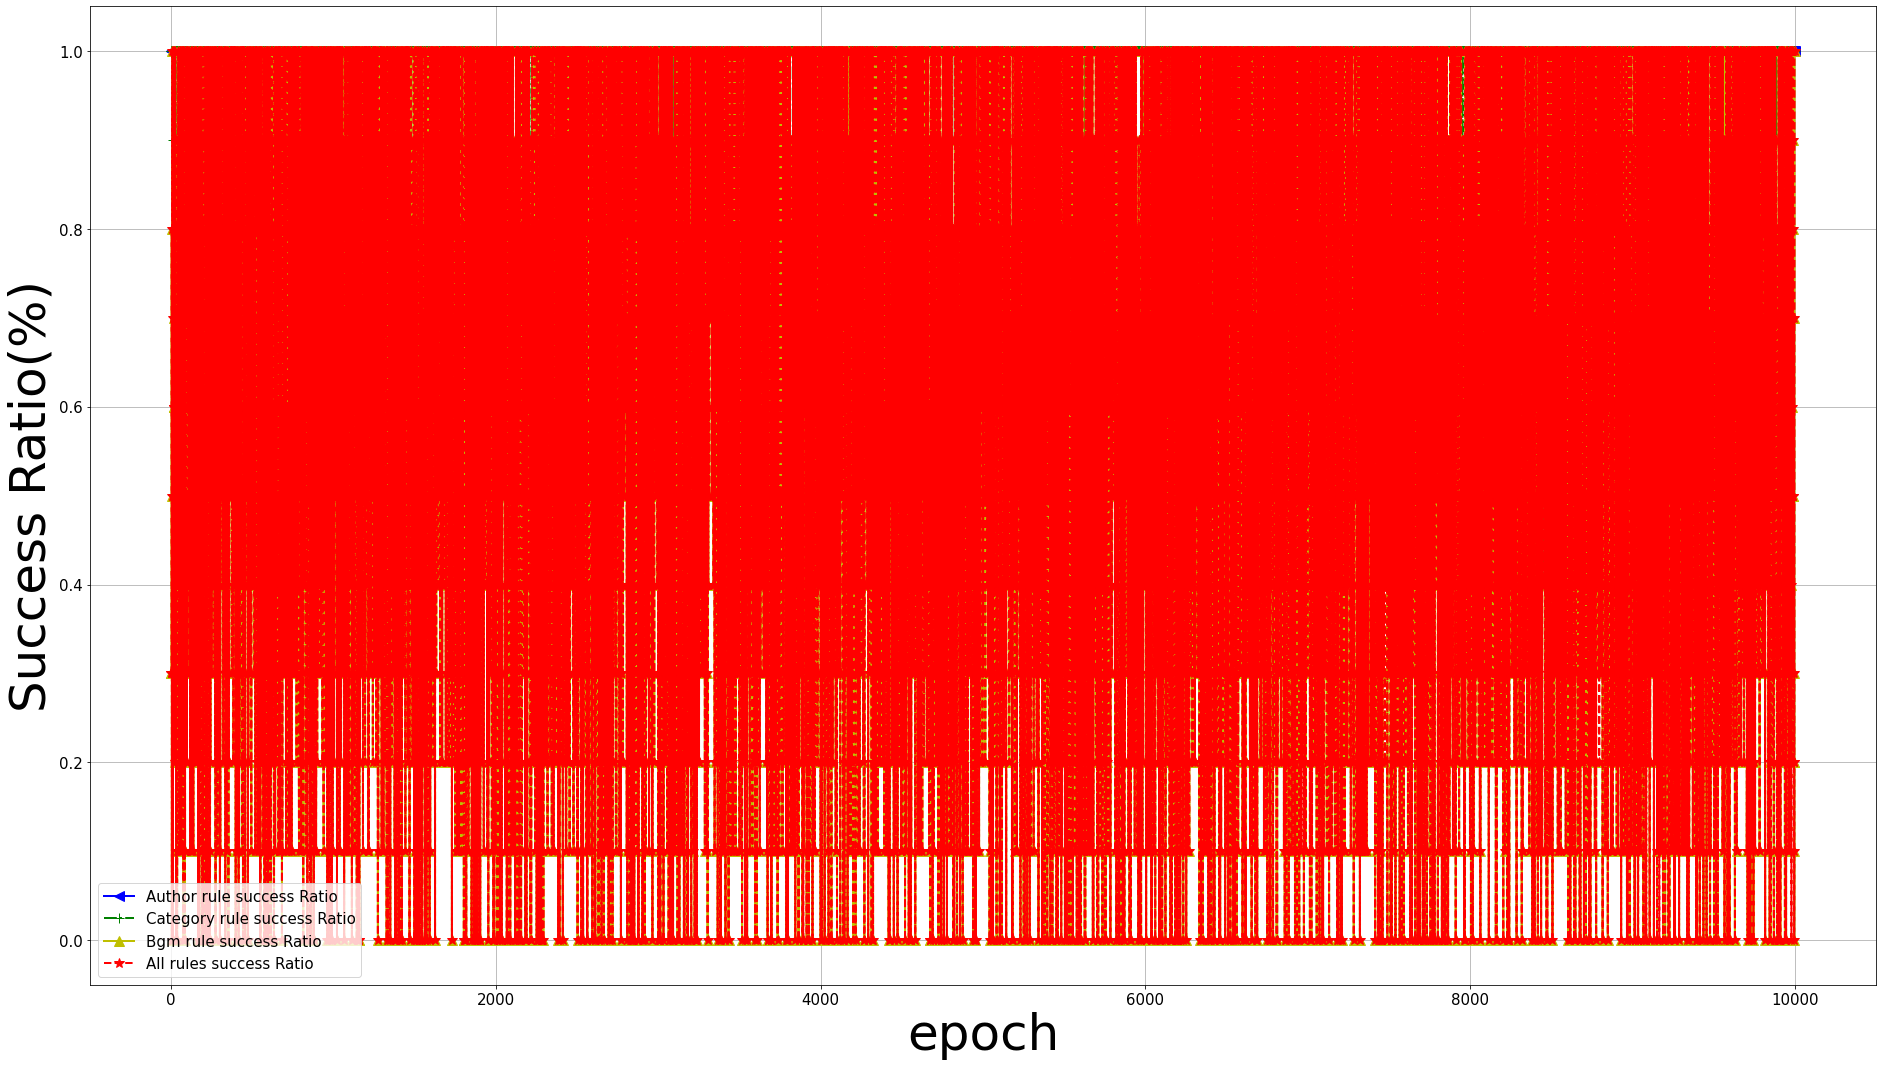

In [233]:
main()

In [234]:
x = [20, 50, 100, 200, 500, 1000, 2000, 5000]
time = [0.0004, 0.001, 0.00215, 0.00432, 0.01082, 0.02151, 0.04156, 0.11231]
all_acc = [74.84, 74.71, 74.77, 74.79, 74.83, 74.82, 74.83, 74.86]
author_acc = [100, 99.99, 99.99, 99.99, 99.99, 99.99, 99.99, 99.99]
cate_acc = [99.79, 99.77, 99.76, 99.77, 99.77, 99.77, 99.77, 99.77]
bgm_acc = [75.00, 74.89, 74.95, 74.97, 75.01, 75.00, 75.01, 75.04]
plt.plot(x, time, 'r*-', markersize=30, linewidth=2, label='time')
# plt.plot(x, all_acc, 'b^-', markersize=30, linewidth=2, label='all success ratio')
# plt.plot(x, author_acc, 'g>-', markersize=30, linewidth=2, label='author success ratio')
# plt.plot(x, cate_acc, 'g<-', markersize=30, linewidth=2, label='cate success ratio')
# plt.plot(x, bgm_acc, 'g<-', markersize=30, linewidth=2, label='bgm success ratio')

# plt.yticks(np.arange(99.5, 101, step=0.5))
plt.grid(which='both')
plt.xlabel('N', fontsize=50)
plt.ylabel('Time(s)', fontsize=50)
plt.tick_params(labelsize=15)
plt.legend(fontsize=50)
plt.show()